# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [97]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-05-31/data_eval_new/"
file_name = "int_norm_20170531_bgd_old.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [98]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [99]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [100]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

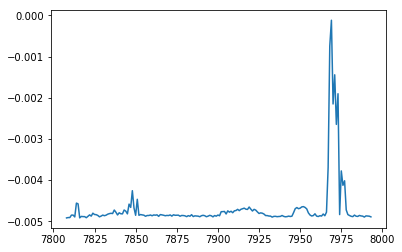

In [101]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

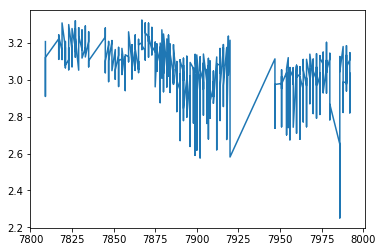

In [102]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

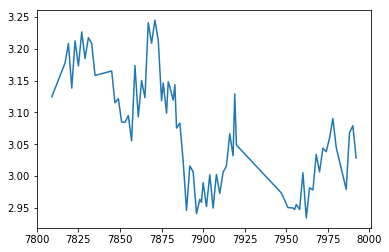

In [103]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

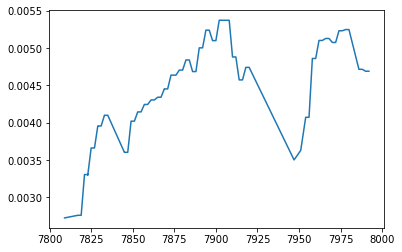

In [104]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [105]:
background_mean = df_mean(background)

# Outlier rejection

In [162]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [163]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [164]:
column = "124/120"
sample = "NIST 200ppb"

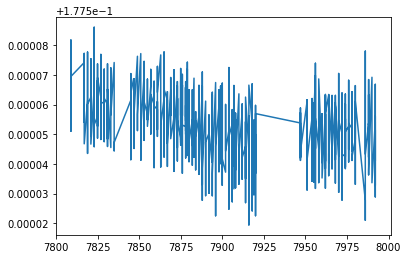

In [165]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [166]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [167]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2017-05-31 20:26:00,NIST 200ppb,2,1,7809,NaN,NaN,0.010358,0.445975,0.235330,0.742935,0.263507,0.142098,0.177565
2017-05-31 20:26:00,NIST 200ppb,2,2,7809,0.029823,0.020189,0.010358,0.445948,0.235328,0.742935,0.263512,0.142095,0.177569
2017-05-31 20:26:00,NIST 200ppb,2,3,7809,0.029827,0.020195,0.010360,0.445975,0.235341,0.742935,0.263521,0.142092,0.177560
2017-05-31 20:26:00,NIST 200ppb,2,4,7809,0.029820,0.020189,0.010359,0.445959,0.235331,0.742935,0.263512,0.142096,0.177572
2017-05-31 20:26:00,NIST 200ppb,2,5,7809,0.029824,0.020192,0.010355,0.445928,0.235331,0.742935,NaN,0.142090,0.177551
2017-05-31 20:26:00,NIST 200ppb,2,6,7809,0.029821,0.020188,0.010360,0.445965,0.235332,0.742935,0.263531,0.142095,0.177580
2017-05-31 20:26:00,NIST 200ppb,2,7,7809,0.029822,0.020191,0.010359,0.445932,0.235330,NaN,0.263516,0.142099,0.177582
2017-05-31 20:26:00,NIST 200ppb,2,8,7809,0.029821,0.020190,0.010361,0.445971,0.235339,0.742935,0.263523,0.142099,0.177571
2017-05-31 20:26:00,NIST 200ppb,2,9,7809,0.029823,0.020191,0.010360,0.445952,0.235326,0.742935,0.263513,0.142105,0.177575


In [168]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
7851        2017-06-01 05:52:00    0.186825
7854        2017-06-01 06:32:00    0.186951
7862        2017-06-01 08:21:00    0.186859
7865        2017-06-01 09:01:00    0.186822
7875        2017-06-01 12:03:00    0.186949
            2017-06-01 12:03:00    0.186874
7878        2017-06-01 12:43:00    0.186884
            2017-06-01 12:43:00    0.186895
7879        2017-06-01 12:58:00    0.186956
7884        2017-06-01 14:06:00    0.186573
7891        2017-06-01 15:41:00    0.186594
            2017-06-01 15:41:00    0.186600
7896        2017-06-01 16:56:00    0.186566
7900        2017-06-01 17:50:00    0.186639
7902        2017-06-01 18:16:00    0.186644
            2017-06-01 18:16:00    0.186607
7906        2017-06-01 19:09:00    0.186609
7907        2017-06-01 19:23:00    0.186630
7908        2017-06-01 19:38:00    0.186625
            2017-06-01 19:38:00    0.186632
7911        2017-06-01 20:24:00    0.186592
7912        2017-06-01 20:38:00    0.186387


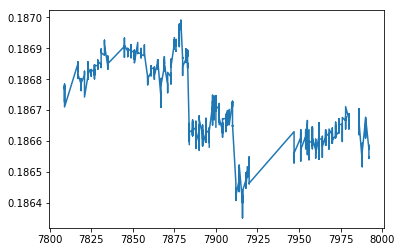

In [169]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [170]:
df[df["Sample"] == sample][column].std()

0.00013626743837008405

In [171]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

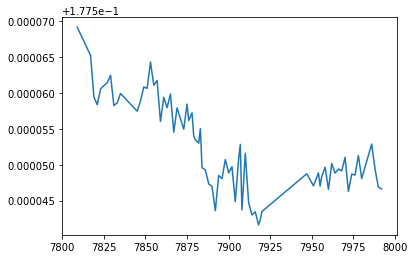

In [172]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [173]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2017-05-31 20:26:00,7809,NIST 200ppb,0.029822,0.020190,0.010360,0.445961,0.235334,0.742935,0.263516,0.142097,0.177569
2017-05-31 20:51:00,7811,NIST 100ppb,0.029824,0.020195,0.010363,0.446001,0.235334,0.742935,0.263515,0.142099,0.177569
2017-05-31 21:17:00,7813,NIST 100ppb,0.029820,0.020188,0.010361,0.445976,0.235329,0.742935,0.263509,0.142101,0.177570
2017-05-31 21:31:00,7814,NIST 100ppb,0.029823,0.020190,0.010360,0.446098,0.235334,0.742935,0.263508,0.142096,0.177566
2017-05-31 21:46:00,7815,NIST 100ppb,0.029824,0.020193,0.010360,0.445950,0.235331,0.742935,0.263508,0.142095,0.177565
2017-05-31 22:11:00,7817,NIST 200ppb,0.029824,0.020193,0.010361,0.445986,0.235329,0.742935,0.263502,0.142093,0.177565
2017-05-31 22:26:00,7818,NIST 100ppb,0.029825,0.020195,0.010358,0.445981,0.235331,0.742935,0.263500,0.142095,0.177562
2017-05-31 22:40:00,7819,NIST 200ppb,0.029824,0.020193,0.010360,0.446009,0.235330,0.742935,0.263504,0.142092,0.177559
2017-05-31 23:06:00,7821,NIST 200ppb,0.029823,0.020192,0.010361,0.445989,0.235332,0.742935,0.263503,0.142091,0.177558


In [174]:
date_list = [pd.Timestamp("2017-06-01 11:05:00")]
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [175]:
drop_sum = [pd.Timestamp("2017-05-31 20:51:00"), 
            pd.Timestamp("2017-05-31 21:17:00"), 
            pd.Timestamp("2017-05-31 21:31:00"), 
            pd.Timestamp("2017-06-01 04:29:00"), 
            pd.Timestamp("2017-06-01 04:43:00"),
            pd.Timestamp("2017-06-01 04:58:00"), 
            pd.Timestamp("2017-06-01 05:23:00"), 
            pd.Timestamp("2017-06-01 05:38:00"), 
            pd.Timestamp("2017-06-01 05:52:00"), 
            pd.Timestamp("2017-06-02 08:48:00"), 
            pd.Timestamp("2017-06-02 09:02:00"),
            pd.Timestamp("2017-06-02 09:28:00"), 
            pd.Timestamp("2017-06-02 09:42:00"), 
            pd.Timestamp("2017-06-02 09:57:00"), 
            pd.Timestamp("2017-06-02 10:22:00"), 
            pd.Timestamp("2017-06-02 10:36:00"), 
            pd.Timestamp("2017-06-02 10:51:00")]

In [176]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [177]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [178]:
data_mean_int_sum

112/120                   114/120                \
                                mean       SD2 count      mean           SD2   
Sample                                                                         
Indarch bomb 1_2            0.029813       NaN     1  0.020186           NaN   
J.W. Leach 2b               0.029820       NaN     1  0.020195           NaN   
J.W. Leach 3a Aliq. 2 bomb  0.029821       NaN     1  0.020192           NaN   
J.W. Leach 4                0.029817       NaN     1  0.020191           NaN   
NIST 100ppb                 0.029821  0.000004    30  0.020191  4.329631e-06   
NIST 200ppb                 0.029823  0.000005    67  0.020192  3.157202e-06   
NIST 200ppb + 0.005ppb U    0.029826  0.000009     2  0.020192  4.184153e-06   
NIST 200ppb + 0.030ppb Cd   0.029825       NaN     1  0.020193           NaN   
NIST 200ppb + 0.100ppb Zr   0.029825       NaN     1  0.020192           NaN   
NIST 200ppb + 0.150ppb Rh   0.029823       NaN     1  0.020192           NaN   
NIST 200ppb + 0.300ppb Ru   0.029823       NaN     1  0.020190           NaN   
NIST 200ppb + 0.50ppb Pd    0.029823       NaN     1  0.020191           NaN   
NIST 200ppb + 0.628ppb Te   0.029824       NaN     1  0.020192           NaN   
NIST 200ppb + 2ppb Mo       0.029822       NaN     1  0.020190           NaN   
NIST 200ppb + 30ppb Ca      0.029820  0.000005     2  0.020190  2.861031e-06   
NIST 200ppb + 65ppb Cr      0.029823  0.000003     2  0.020192  2.365330e-06   
NIST 200ppb + ME            0.029828       NaN     1  0.020193           NaN   
Nod P1 1911                 0.029820       NaN     1  0.020191           NaN   
ZH09-05 23.3_1_8            0.029820       NaN     1  0.020188           NaN   
ZH09-05 23.3_3b_3 Aliq. 3   0.029822  0.000002     2  0.020194  3.440936e-07   
ZH09-05 23.3_3b_3 Aliq. 4   0.029823       NaN     1  0.020194           NaN   

                                   115/120                       116/120  \
                           count      mean           SD2 count      mean   
Sample                                                                     
Indarch bomb 1_2               1  0.010359           NaN     1  0.445958   
J.W. Leach 2b                  1  0.010360           NaN     1  0.445991   
J.W. Leach 3a Aliq. 2 bomb     1  0.010360           NaN     1  0.445992   
J.W. Leach 4                   1  0.010361           NaN     1  0.445985   
NIST 100ppb                   30  0.010362  2.428497e-06    30  0.445985   
NIST 200ppb                   67  0.010361  1.287500e-06    67  0.445994   
NIST 200ppb + 0.005ppb U       2  0.010362  5.705286e-07     2  0.446006   
NIST 200ppb + 0.030ppb Cd      1  0.010361           NaN     1  0.445989   
NIST 200ppb + 0.100ppb Zr      1  0.010362           NaN     1  0.445995   
NIST 200ppb + 0.150ppb Rh      1  0.010362           NaN     1  0.445986   
NIST 200ppb + 0.300ppb Ru      1  0.010362           NaN     1  0.445995   
NIST 200ppb + 0.50ppb Pd       1  0.010362           NaN     1  0.445991   
NIST 200ppb + 0.628ppb Te      1  0.010362           NaN     1  0.445997   
NIST 200ppb + 2ppb Mo          1  0.010360           NaN     1  0.445986   
NIST 200ppb + 30ppb Ca         2  0.010361  2.457817e-07     2  0.445994   
NIST 200ppb + 65ppb Cr         2  0.010361  2.187833e-06     2  0.445999   
NIST 200ppb + ME               1  0.010362           NaN     1  0.446002   
Nod P1 1911                    1  0.010363           NaN     1  0.445990   
ZH09-05 23.3_1_8               1  0.010362           NaN     1  0.445987   
ZH09-05 23.3_3b_3 Aliq. 3      2  0.010361  3.460911e-07     2  0.445991   
ZH09-05 23.3_3b_3 Aliq. 4      1  0.010361           NaN     1  0.445992   

                            ...  118/120   119/120                   122/120  \
                            ...    count      mean       SD2 count      mean   
Sample                      ...                                                
Indarch bomb 1_2            ...        1  0

In [179]:
date_list = [pd.Timestamp("2017-05-31 20:51:00"), 
            pd.Timestamp("2017-05-31 21:17:00"), 
            pd.Timestamp("2017-05-31 21:31:00"), 
            pd.Timestamp("2017-06-01 04:29:00"), 
            pd.Timestamp("2017-06-01 04:43:00"),
            pd.Timestamp("2017-06-01 04:58:00"), 
            pd.Timestamp("2017-06-01 05:23:00"), 
            pd.Timestamp("2017-06-01 05:38:00"), 
            pd.Timestamp("2017-06-01 05:52:00"), 
            pd.Timestamp("2017-06-02 08:48:00"), 
            pd.Timestamp("2017-06-02 09:02:00"),
            pd.Timestamp("2017-06-02 09:28:00"), 
            pd.Timestamp("2017-06-02 09:42:00"), 
            pd.Timestamp("2017-06-02 09:57:00"), 
            pd.Timestamp("2017-06-02 10:22:00"), 
            pd.Timestamp("2017-06-02 10:36:00"), 
            pd.Timestamp("2017-06-02 10:51:00")]


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)
epsilon_int_100 = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_100 = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)

In [180]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-05-31 20:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 200ppb
2017-05-31 21:46:00,2.559836,0.337521,0.943980,-0.297033,-0.533874,0.000069,-1.110223e-12,-0.035453,-0.010190,-0.146206,NIST 100ppb
2017-05-31 22:11:00,3.839263,0.337946,0.675160,0.449851,0.027967,-0.116464,2.220446e-12,-0.310734,-0.100738,0.051692,NIST 200ppb
2017-05-31 22:26:00,0.000000,0.449992,1.205690,-2.228338,-0.366296,0.065455,-1.110223e-12,-0.092094,0.179526,0.003372,NIST 100ppb
2017-05-31 22:40:00,0.000000,0.029611,0.251865,-0.417377,0.479854,-0.021313,-1.110223e-12,0.054800,0.008506,-0.132461,NIST 200ppb
2017-05-31 23:06:00,0.000000,0.110397,0.258960,0.504106,-0.210473,0.021605,2.220446e-12,0.064463,-0.044844,-0.092022,NIST 200ppb
2017-05-31 23:20:00,0.000000,-0.238145,-0.236699,-0.342708,-0.075323,-0.088455,-1.110223e-12,0.090283,-0.055821,-0.077132,NIST 200ppb + 2ppb Mo
2017-05-31 23:35:00,0.000000,-0.353282,-0.826198,-0.661356,-0.043542,0.063200,0.000000e+00,-0.108314,0.013835,0.048529,NIST 200ppb
2017-06-01 00:00:00,0.000000,0.413605,0.704501,0.540063,0.078193,0.013332,-3.330669e-12,0.032391,-0.068459,0.002434,NIST 200ppb


In [181]:

date_list = []

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [182]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [183]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)
epsilon_int_100 = epsilon_process(epsilon_int_100)
delta_raw_100 = epsilon_process(delta_raw_100)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [184]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-05-31 22:26:00,7818,0.449992,1.205690,-2.228338,-0.366296,0.065455,-1.110223e-12,-0.092094,0.179526,0.003372,NIST 100ppb
2017-05-31 22:40:00,7819,0.029611,0.251865,-0.417377,0.479854,-0.021313,-1.110223e-12,0.054800,0.008506,-0.132461,NIST 200ppb
2017-05-31 23:06:00,7821,0.110397,0.258960,0.504106,-0.210473,0.021605,2.220446e-12,0.064463,-0.044844,-0.092022,NIST 200ppb
2017-05-31 23:20:00,7822,-0.238145,-0.236699,-0.342708,-0.075323,-0.088455,-1.110223e-12,0.090283,-0.055821,-0.077132,NIST 200ppb + 2ppb Mo
2017-05-31 23:35:00,7823,-0.353282,-0.826198,-0.661356,-0.043542,0.063200,0.000000e+00,-0.108314,0.013835,0.048529,NIST 200ppb
2017-06-01 00:00:00,7825,0.413605,0.704501,0.540063,0.078193,0.013332,-3.330669e-12,0.032391,-0.068459,0.002434,NIST 200ppb
2017-06-01 00:15:00,7826,-0.156934,0.283644,0.324259,0.036594,0.196349,0.000000e+00,0.024059,-0.124604,-0.277149,NIST 200ppb + 0.50ppb Pd
2017-06-01 00:29:00,7827,-0.626899,-0.769967,-0.191376,-0.088717,-0.130221,4.440892e-12,-0.040974,0.134642,-0.018635,NIST 200ppb
2017-06-01 00:55:00,7829,0.101511,0.222146,0.035706,0.002408,0.097933,-1.110223e-12,0.111866,0.050352,0.148478,NIST 200ppb


In [185]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_100_sum = np.round(epsilon_int_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_100_sum = np.round(delta_raw_100.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum.append(epsilon_int_100_sum)
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum.append(delta_raw_100_sum)
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [186]:
epsilon_sum_all

112/120              114/120              115/120  \
                              mean    SD2 count    mean    SD2 count    mean   
Sample                                                                         
Indarch bomb 1_2            -1.785    NaN     1  -1.788    NaN     1  -0.841   
J.W. Leach 3a Aliq. 2 bomb  -0.675    NaN     1  -0.290    NaN     1  -2.119   
NIST 100ppb                 -0.114  1.596     2  -0.458  4.706     2  -1.442   
NIST 200ppb                 -0.008  0.925    55  -0.019  1.356    55   0.005   
NIST 200ppb + 0.005ppb U     0.551  0.052     2   0.122  1.628     2   0.447   
NIST 200ppb + 0.030ppb Cd   -0.112    NaN     1   0.929    NaN     1  -0.391   
NIST 200ppb + 0.100ppb Zr   -0.123    NaN     1  -0.299    NaN     1   0.542   
NIST 200ppb + 0.150ppb Rh    0.269    NaN     1   0.011    NaN     1  -0.479   
NIST 200ppb + 0.300ppb Ru   -0.045    NaN     1  -0.477    NaN     1   0.805   
NIST 200ppb + 0.50ppb Pd    -0.157    NaN     1   0.284    NaN     1   0.324   
NIST 200ppb + 0.628ppb Te   -0.253    NaN     1   0.107    NaN     1  -0.022   
NIST 200ppb + 2ppb Mo       -0.238    NaN     1  -0.237    NaN     1  -0.343   
NIST 200ppb + 30ppb Ca      -0.445  0.385     2  -0.434  0.686     2  -0.471   
NIST 200ppb + 65ppb Cr       0.516  0.828     2   0.225  0.611     2   0.165   
NIST 200ppb + ME             1.153    NaN     1   0.869    NaN     1   0.454   
Nod P1 1911                 -0.068    NaN     1   0.103    NaN     1   1.021   
ZH09-05 23.3_3b_3 Aliq. 3   -0.301  0.696     2   0.389  2.404     2  -0.112   
ZH09-05 23.3_3b_3 Aliq. 4    0.315    NaN     1   1.457    NaN     1  -0.725   
J.W. Leach 2b               -0.040    NaN     1   1.618    NaN     1  -1.156   
J.W. Leach 4                -1.103    NaN     1   0.451    NaN     1  -0.041   
NIST 100ppb                  0.062  1.191    22   0.104  2.187    22   0.143   
NIST 200ppb                 -0.068  0.583     3  -0.296  2.376     3   0.417   
ZH09-05 23.3_1_8            -0.078    NaN     1   0.314    NaN     1   0.277   

                                        116/120  ...  118/120 119/120         \
                              SD2 count    mean  ...    count    mean    SD2   
Sample                                           ...                           
Indarch bomb 1_2              NaN     1  -0.508  ...        1  -0.501    NaN   
J.W. Leach 3a Aliq. 2 bomb    NaN     1  -0.045  ...        1   0.107    NaN   
NIST 100ppb                 2.223     2  -0.224  ...        2  -0.027  0.184   
NIST 200ppb                 1.344    55   0.008  ...       55   0.002  0.140   
NIST 200ppb + 0.005ppb U    0.589     2   0.091  ...        2   0.118  0.049   
NIST 200ppb + 0.030ppb Cd     NaN     1  -0.083  ...        1  -0.109    NaN   
NIST 200ppb + 0.100ppb Zr     NaN     1  -0.030  ...        1   0.006    NaN   
NIST 200ppb + 0.150ppb Rh     NaN     1  -0.182  ...        1   0.068    NaN   
NIST 200ppb + 0.300ppb Ru     NaN     1   0.033  ...        1   0.077    NaN   
NIST 200ppb + 0.50ppb Pd      NaN     1   0.037  ...        1   0.024    NaN   
NIST 200ppb + 0.628ppb Te     NaN     1  -0.036  ...        1  -0.136    NaN   
NIST 200ppb + 2ppb Mo         NaN     1  -0.075  ...        1   0.090    NaN   
NIST 200ppb + 30ppb Ca      0.522     2   0.009  ...        2   0.014  0.144   
NIST 200ppb + 65ppb Cr      0.226     2   0.089  ...        2   0.040  0.093   
NIST 200ppb + ME              NaN     1   0.148  ...        1   0.146    NaN   
Nod P1 1911                   NaN     1  -0.047  ...        1   0.493    NaN   
ZH09-05 23.3_3b_3 Aliq. 3   0.464     2  -0.030  ...        2  -0.150  0.049   
ZH09-05 23.3_3b_3 Aliq. 4     NaN     1   0.014  ...        1  -0.032    NaN   
J.W. Leach 2b                 NaN     1   0.103  ...        1  -0.009    NaN   
J.W. Leach 4                  NaN     1   0.056  ...        1  -0.053    NaN   
NIST 100ppb                 2.691    22   0.009  ...       22   0.005  0.220   
NIST 200ppb               

In [131]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200.append(epsilon_int_100), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200.append(delta_raw_100), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

SyntaxError: invalid syntax (<ipython-input-131-46d5f69f4564>, line 6)

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [171]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [172]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [187]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_old.xlsx', engine='xlsxwriter')


In [188]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.append(epsilon_int_100).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.append(delta_raw_100).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [189]:
writer_orig.save()

In [ ]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

In [190]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')